# **TP Wavelets**

In this TP, we will work on some fundamental concepts in Wavelets and compression of images.

First we'll briefly check the limitations of the Fourier transform. We'll then check some fundamental properties of a family of Wavelets and compute the Wavelet transform of a very simple signal. In the second part of the TP, we will use the DWT to compress an image.

Make sure to sequentially run all the cells in each section, so that the intermediate variables / packages will carry over to the next cell

We recommend you save a copy of this colab in your drive so you don't lose progress!

**Note 1:** As mentioned in the course and since there's not any policy regarding ChatGPT at Télécom level yet, you can use it. However, using ChatGPT without understanding their outputs is not OK, and will be penalized accordingly in your grade. Please be sure of all the functions you'll use.

**Note 2:** Several points have associated questions. When answering these questions, all responses should be properly justified. ChatGPT answers are very easy to spot.

**Note 3:** Always plot the functions and outputs you're generating. If the output or function is not properly plotted/shown, this will reduce points in your grade.

# Setup
First, we install PyWavelets

In [1]:
!pip install PyWavelets

In [2]:
import pywt

pywt.__version__

'1.1.1'

# Important
Google Colab is an interesting tool to try things out quickly. However, Google Colab and more general Notebooks are not meant to be an Integrated Development Environment (IDE). For a real job, please use an actual IDE like PyCharm or VS Code.

# Limitation of the Fourier Transform
*   Create a sinusoidal signal of 2.5 seconds of duration.
*   Set up a sampling rate of 20kHz. The signal should be divided in 5 parts of 0.5 seconds of duration each.
*  The signal should have the following frequencies in this order {10 Hz, 30 Hz, 60 Hz, 30 Hz, 10 Hz}.

In [3]:
# Your code here
import numpy as np

duration = 2.5
sampling_rate = 20000
frequencies = [10, 30, 60, 30, 10]
time = np.linspace(0, duration, int(duration * sampling_rate))
signal = np.concatenate([np.sin(2 * np.pi * f * time[i * sampling_rate // 2:(i + 1) * sampling_rate // 2]) for i, f in enumerate(frequencies)])

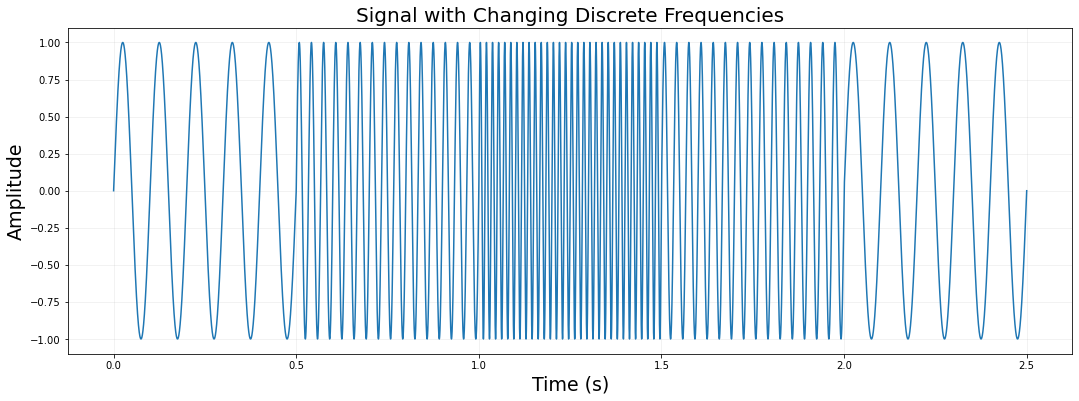

In [4]:
import matplotlib
import matplotlib.pyplot as plt

font_size = 20

plt.figure(figsize=(18, 6))

plt.plot(time, signal, linewidth=1.5)
plt.title('Signal with Changing Discrete Frequencies', fontsize=font_size)
plt.xlabel('Time (s)', fontsize=font_size-1)
plt.ylabel('Amplitude', fontsize=font_size-1)
plt.grid(alpha=0.2)

Now, you should compute the Discrete Fourier Transform of the signal. You can use any library from Python you prefer. You might need to cut the x-axis in the Fourier transform up to 100 Hz in the visualization. Please check https://numpy.org/doc/stable/reference/generated/numpy.fft.fft.html and https://numpy.org/doc/stable/reference/generated/numpy.fft.fftfreq.html

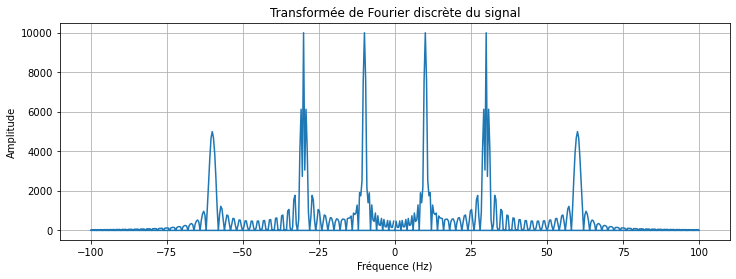

In [5]:
# Your code here
fft_signal = np.fft.fft(signal)
frequencies_fft = np.fft.fftfreq(len(signal), 1 / sampling_rate)

mask = np.abs(frequencies_fft) <= 100

plt.figure(figsize=(12, 4))
plt.plot(frequencies_fft[mask], np.abs(fft_signal)[mask])
plt.title('Transformée de Fourier discrète du signal')
plt.xlabel('Fréquence (Hz)')
plt.ylabel('Amplitude')
plt.grid()
plt.show()

**QUESTIONS**

1) Does the established sampling rate satisfy the Nyquist-Shannon sampling theorem to avoid aliasing? Please justify.

2) What can you say from the signal looking **only** at the Fourier transform?

3) Can you be certain about the location of some frequency component in the time domain? Why?

**YOUR ANSWERS HERE:**

1) Yes, the sampling rate satisfies the Nyquist-Shannon theorem. The sampling rate is 20 kHz, which is much higher than twice the highest frequency in the signal, 60 Hz. This means aliasing is avoided, as the sampling rate is more than sufficient to capture the signal accurately.

2) Looking only at the Fourier transform, we can see peaks at the main frequencies: 10 Hz, 30 Hz, and 60 Hz. This shows us which frequencies are present in the signal. We also know the signal is real because its Fourier transform is symmetric.

3) No, we can't be sure of the exact timing of each frequency. Heisenberg’s uncertainty principle says there is a trade-off between knowing the frequency and time information of a signal. By using the Fourier transform over the whole signal, we focused on frequency information, which means we lost all information about when each frequency appears. To see both time and frequency, we would need to use methods like the short-time Fourier transform or wavelet transform.

# **Mother Wavelet**
As we saw in the course, a wavelet is not just a function but a whole family of functions that satisfy certain requirements. In this part of the TP we're gonna work with the Morlet wavelet defined as follows: $\Psi(t)=k e^{iw_0t}e^{-\frac{1}{2}(\frac{t}{\sigma})^2}$. Please generate a Morlet wavelet in Python **WITHOUT using PyWavelets** with the following parameters:

-Center frequency of the wavelet = 10 Hz

-Sampling rate $\eta$ = 20000 Hz

-$k=\frac{1}{\sqrt{\eta}}$

-$\sigma = 0.1$

You can generate the wavelet between -1 and 1 seconds, so the time duration of the wavelet is 2 seconds. For this part, you just need to generate the real part of the wavelet.

Text(0, 0.5, 'Amplitude')

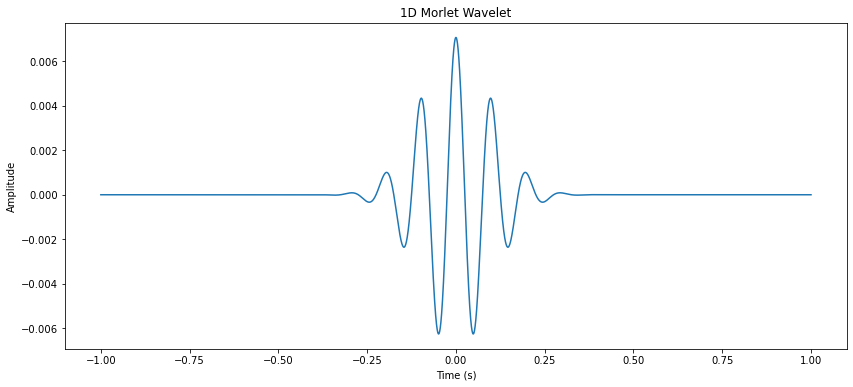

In [6]:
# Your code here
center_freq = 10
sampling_rate_wavelet = 20000
sigma = 0.1
k = 1 / np.sqrt(sampling_rate_wavelet)

t_wavelet = np.linspace(-1, 1, int(2 * sampling_rate_wavelet))
morlet_wavelet_real = k * np.cos(2 * np.pi * center_freq * t_wavelet) * np.exp(-0.5 * (t_wavelet / sigma) ** 2)

# Plot the real part of the Morlet wavelet in 1D
plt.figure(figsize=(14, 6))

plt.plot(t_wavelet, morlet_wavelet_real)
plt.title('1D Morlet Wavelet')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')

Please show that the mother wavelet we just created satisfies the admissibility and the finite energy conditions:

In [7]:
# Your code here
l2_norm = np.sqrt(np.sum(np.abs(morlet_wavelet_real)**2))

if np.isfinite(l2_norm):
    print("The wavelet satisfies the finite energy condition")
else:
    print("The wavelet does not satisfy the finite energy condition")

mean = np.mean(morlet_wavelet_real)

if abs(mean) < 1e-10:
    print("The wavelet satisfies the admissibility condition")
else:
    print("The wavelet does not satisfy the admissibility condition")

The wavelet satisfies the finite energy condition
The wavelet satisfies the admissibility condition


**Note:** In real life, you have to deal with finite-precision related problems. Therefore, if for the admissibility condition you don't have exactly the value you were expecting for, don't worry.

# **Convolution**

As we saw in the course, we need a measure of similarity to compute the wavelet transform. We also saw that we can easily compute the shift in time and similarity calculation with the 1-D convolutions.

* Generate a chirp sinusoidal signal from -5 to 5 seconds with an initial frequency of 5 Hz and final frequency of 15 Hz and sampling rate of 20kHz:

Text(0.5, 0, 'Time')

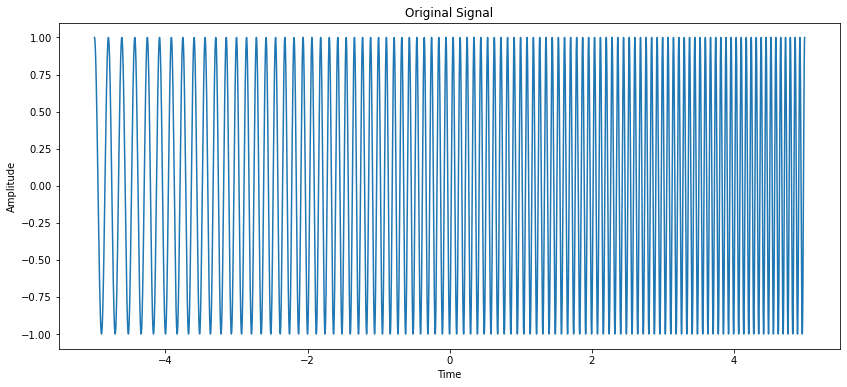

In [8]:
# Your code here
from scipy.signal import chirp

sampling_rate = 20000

time_signal = np.linspace(-5, 5, int(10 * sampling_rate))
signal = chirp(time_signal + 5, f0=5, f1=15, t1=10)
plt.figure(figsize=(14, 6))
plt.plot(time_signal, signal)
plt.title('Original Signal')
plt.ylabel('Amplitude')
plt.xlabel('Time')

Now create a Morlet wavelet with the following parameters:

* Center frequency of the wavelet = 10 Hz

* Sampling rate $\eta$ = 20000 Hz

* $k=\frac{1}{\sqrt{\eta}}$
* $\sigma = 0.2$
* Duration = 2 seconds


Compute the convolution between the signal and $Re(\Psi(t))$. For reference on how to perform convolution with scipy 'convolve' function, please check https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.convolve.html

Text(0, 0.5, 'Amplitude')

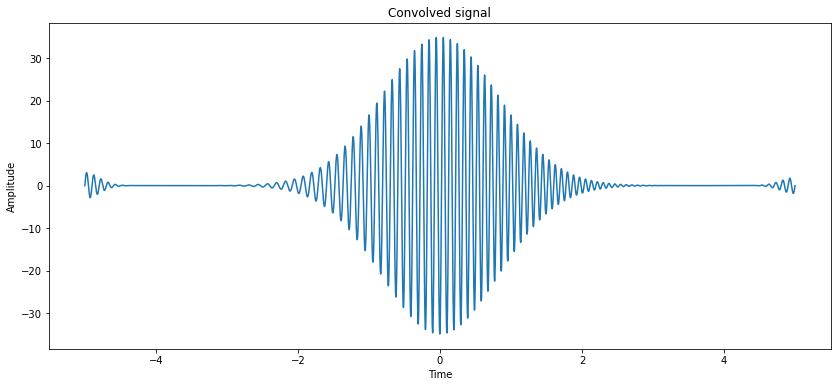

In [9]:
# Your code here
from scipy.signal import convolve

center_freq = 10
sampling_rate_wavelet = 20000
sigma = 0.2
k = 1 / np.sqrt(sampling_rate_wavelet)

t_wavelet = np.linspace(-1, 1, int(2 * sampling_rate_wavelet))
morlet_wavelet = k * np.exp(1j * 2 * np.pi * center_freq * t_wavelet) * np.exp(-0.5 * (t_wavelet / sigma) ** 2)

convolved_signal = convolve(signal, np.real(morlet_wavelet), mode='same')

plt.figure(figsize=(14, 6))
plt.plot(time_signal, convolved_signal)
plt.title('Convolved signal')
plt.xlabel('Time')
plt.ylabel('Amplitude')

There are some points where the convolution is zero, even in regions of high similarity between the wavelet and the signal. **Is this OK?** If it's not, propose a solution to that.

No, it’s not okay to have zero values in regions of high similarity. The convolution between the signal and the wavelet works like a point-by-point dot product to measure frequency similarity at each location. So, in areas where the frequencies match, we should get a non-zero result. However, because we only used the real part of the wavelet, some points have destructive interference due to phase differences. In those points, the imaginary part, which is shifted by pi/2 radians, should have constructive interference with the signal and show the correlation at that point with this frequency. To solve this, we should use the full complex wavelet for the convolution and then take the modulus to correctly show where the signal is highly correlated with the wavelet’s frequency

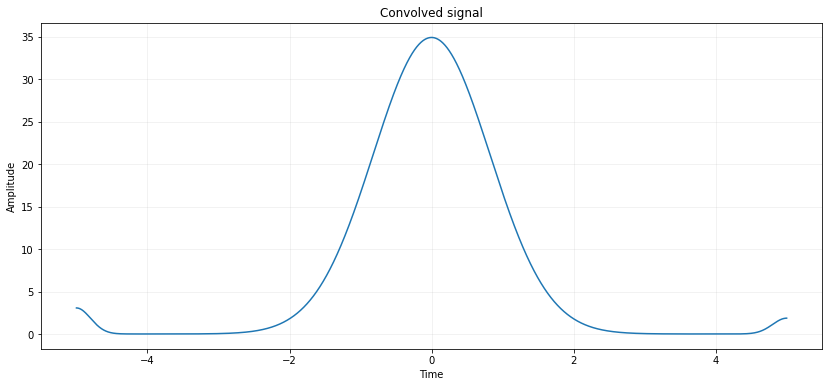

In [10]:
# Your code here

complex_convolved_signal = convolve(signal, morlet_wavelet, mode='same')

plt.figure(figsize=(14, 6))
plt.plot(time_signal, np.abs(complex_convolved_signal))
plt.title('Convolved signal')
plt.ylabel('Amplitude')
plt.xlabel('Time')
plt.grid(alpha=0.2)

# **Image Compression**
For this part, we'll use the Discrete Wavelet Transform (DWT) implemented as a filter bank to do image compression. The first step is to have an image to compress. For doing so you can use the following piece of code to download an image of Trudy.

In [11]:
!wget https://raw.githubusercontent.com/jhonygiraldo/jhonygiraldo.github.io/main/Trudy_for_compression.jpeg

'wget' n'est pas reconnu en tant que commande interne
ou externe, un programme ex�cutable ou un fichier de commandes.


**Visualize image:** With the following code you can visualize the image. If you're using Google Collab, most probably you already have the open cv library installed. If you're using Jupyter Notebook for example, you'll have to install open cv if it's not already installed.

In [12]:
# Let us define a function for visualizing images
def show_image(image, title='Input Image', font_size=12,fig_size = (10, 10)):
  #A function that uses matplotlib to show grayscale images
  plt.figure(figsize=fig_size)
  plt.imshow(image, cmap='gray')
  plt.title(title, fontsize=font_size)
  plt.axis('off')

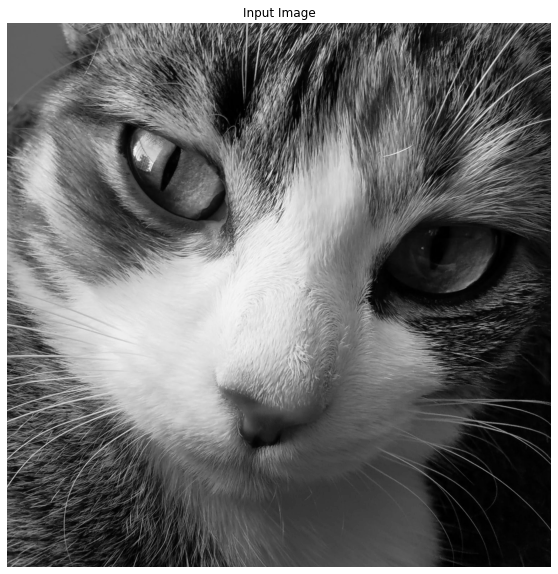

In [13]:
import cv2

# Load your image as a grayscale
input_image = cv2.imread('Trudy_for_compression.jpeg', cv2.IMREAD_GRAYSCALE)
# Display the original image
show_image(input_image, 'Input Image')

If you use some wavelet function (Biorthogonal 1.3 in this case), the 1-level 2D wavelet decomposition of our input image is given as follows:

In [14]:
# # You can see a list of wavelet families
import pywt
pywt.families()

['haar',
 'db',
 'sym',
 'coif',
 'bior',
 'rbio',
 'dmey',
 'gaus',
 'mexh',
 'morl',
 'cgau',
 'shan',
 'fbsp',
 'cmor']

In [15]:
# For each family, you can list the available wavelets
pywt.wavelist(family='bior', kind='all')

['bior1.1',
 'bior1.3',
 'bior1.5',
 'bior2.2',
 'bior2.4',
 'bior2.6',
 'bior2.8',
 'bior3.1',
 'bior3.3',
 'bior3.5',
 'bior3.7',
 'bior3.9',
 'bior4.4',
 'bior5.5',
 'bior6.8']

In the previous image we applied a threshold in the wavelet coefficients for visualization purposes. **Please explain the meaning of each of these 4 images**.


**YOUR ANSWER HERE:** 

Top left : Contains low frequencies of the image in both directions, showing general shapes and brightness of the image.  
Bottom left : Contains high vertical frequencies of the image, capturing horizontal edges which are vertical HF.  
Top right : Contains high horizontal frequencies of the image, capturing vertical edges which are horizontal HF.  
Bottom right : Contains high diagonal frequencies of the image.



Now, you should compute the six-levels 2D wavelet decomposition of the input image with a Daubechies wavelet with six vanishing moments using the PyWavelet library. Please check https://pywavelets.readthedocs.io/en/latest/ref/2d-dwt-and-idwt.html#d-multilevel-decomposition-using-wavedec2

In [16]:
# Your code here
coeffs = pywt.wavedec2(input_image, 'db6', level=6)

* Set a threshold of value of 100 and take to zero the values less than that in the 2D wavelet decomposition. **Note:** You should only threshold the outputs of the high-pass filters.


In [17]:
# Your code here
threshold = 100
coeffs_thresholded = [coeffs[0]]
for detail_level in coeffs[1:]:
    coeffs_thresholded.append(tuple(np.where(np.abs(detail) < threshold, 0, detail) for detail in detail_level))


* Compute the IDWT to reconstruct the image after the "compression". Check https://pywavelets.readthedocs.io/en/latest/ref/2d-dwt-and-idwt.html#d-multilevel-reconstruction-using-waverec2 as a reference.

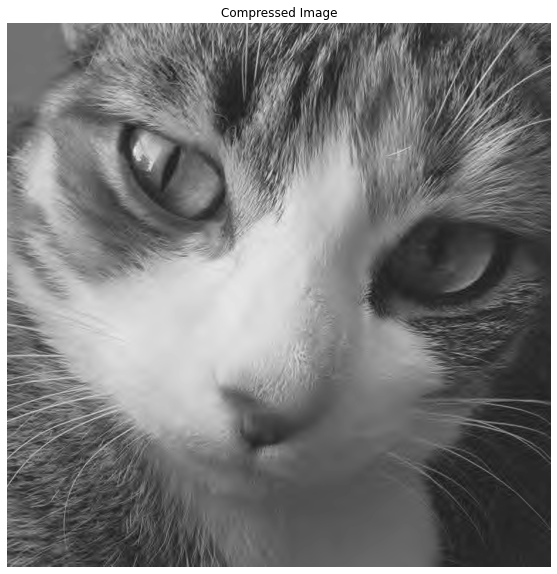

In [18]:
# Your code here
compressed_image = pywt.waverec2(coeffs_thresholded, 'db6')

#plot compressed image
show_image(compressed_image, 'Compressed Image')

What's the compression ratio?

In [19]:
# Your code here
coeffs_array, _ = pywt.coeffs_to_array(coeffs)
coeffs_thresholded_array, _ = pywt.coeffs_to_array(coeffs_thresholded)
coeff_number = np.count_nonzero(coeffs_array)
coeff_thresholded_number = np.count_nonzero(coeffs_thresholded_array)

compression_ratio = coeff_number / coeff_thresholded_number
print(f"Taux de compression : {compression_ratio:.2f}")

Taux de compression : 82.23


# **Putting everything together**

In this exercise we'll analyze the Peak Signal to Noise Ratio (PSNR) of the compressed images for different thresholds. For doing so, we'll give you the function to compute the PSNR between the original and compressed image.

In [20]:
def psnr(original_image, compressed_image):
    h,w = original_image.shape
    mse = np.sum(np.abs(original_image-compressed_image)**2)/(h*w)
    return 20* np.log10(255**2/mse)

Now, you have to create a function codec that receives the input image, the wavelet to be used, the number of levels, and the threshold value. This function returns the compressed image and the compression ratio. **Note:** You already did that previously.

In [21]:
def codec(input_image,wavelet='db4',num_levels=6,threshold=100):
  # Your code here
  coeffs = pywt.wavedec2(input_image, wavelet, level=num_levels)
  coeffs_thresholded = [coeffs[0]]
  for detail_level in coeffs[1:]:
    coeffs_thresholded.append(tuple(np.where(np.abs(detail) < threshold, 0, detail) for detail in detail_level))
  compressed_image = pywt.waverec2(coeffs_thresholded, wavelet)

  coeffs_array, _ = pywt.coeffs_to_array(coeffs)
  coeffs_thresholded_array, _ = pywt.coeffs_to_array(coeffs_thresholded)
  coeff_number = np.count_nonzero(coeffs_array)
  coeff_thresholded_number = np.count_nonzero(coeffs_thresholded_array)

  compression_ratio = coeff_number / coeff_thresholded_number
  
  return compressed_image, compression_ratio

Now, we compare the performance of the 'db4' and the 'bior1.3' wavelets in terms of compression ratio and PSNR for different thresholds.

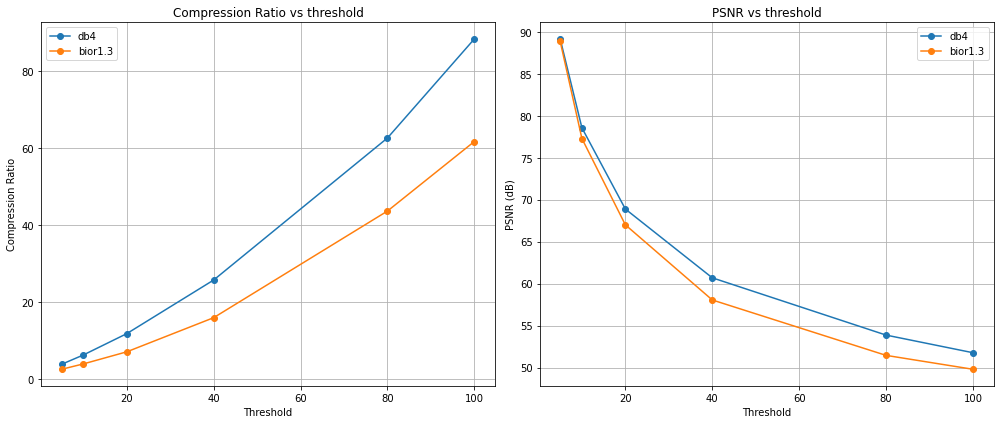

In [22]:
wavelet_1 = 'db4'
wavelet_2 = 'bior1.3'
thresholds = [5,10,20,40,80,100]
num_levels=6

# Your code here

compression_ratios_1 = []
compression_ratios_2 = []
psnr_values_1 = []
psnr_values_2 = []

for threshold in thresholds:
    compressed_image_1, compression_ratio_1 = codec(input_image,wavelet_1,num_levels,threshold)
    compressed_image_2, compression_ratio_2 = codec(input_image,wavelet_2,num_levels,threshold)

    psnr_1 = psnr(input_image,compressed_image_1[:input_image.shape[0],:])
    psnr_2 = psnr(input_image,compressed_image_2[:input_image.shape[0],:])

    compression_ratios_1.append(compression_ratio_1)
    compression_ratios_2.append(compression_ratio_2)

    psnr_values_1.append(psnr_1)
    psnr_values_2.append(psnr_2)

plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.plot(thresholds, compression_ratios_1, label="db4", marker='o')
plt.plot(thresholds, compression_ratios_2, label="bior1.3", marker='o')
plt.xlabel("Threshold")
plt.ylabel("Compression Ratio")
plt.title("Compression Ratio vs threshold")
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(thresholds, psnr_values_1, label="db4", marker='o')
plt.plot(thresholds, psnr_values_2, label="bior1.3", marker='o')
plt.xlabel("Threshold")
plt.ylabel("PSNR (dB)")
plt.title("PSNR vs threshold")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


**QUESTIONS**

1) Which wavelet is better for the Trudy_for_compression.jpeg image and why?

The 'db4' wavelet is better for the image because it achieves both a higher compression ratio and a higher PSNR across all threshold levels. A higher compression ratio means more efficient data reduction, while a higher PSNR indicates that the compressed image retains more of the original image's quality. So, the 'db4' wavelet is more effective for the compression of the Trudy_for_compression.jpeg image.

# Supplementary Exercises (Optional)
1. Designing and using custom filters with the pyWavelets library
Reference (https://pywavelets.readthedocs.io/en/latest/ref/wavelets.html#wavelet-families)
2. Propose and explore custom wavelets that achieve equivalent or higher compression ratio on the Trudy image explored previously. **P.S** You are free to explore any approach here.